In [1]:
from mesa import Agent, Model
from mesa.time import RandomActivation, BaseScheduler
import pandas as pd
import geopandas as gpd
import shapely
from shapely.geometry import Polygon, Point, MultiPoint, box
import math
import matplotlib.pyplot as plt
import numpy as np
from numpy import exp
from numpy.random import rand, seed
import folium
import random 
from haversine import haversine
import plotly.express as px
import base64
from io import BytesIO
from IPython.display import IFrame
pd.options.mode.chained_assignment = None  # default='warn'

In [159]:
class ConstructionSite(Agent): 
    def __init__(self, unique_id, model, buildingType, coords, inA10):
        super().__init__(unique_id, model)
        self.buildingType = buildingType # A, B, C...etc. 
        self.coords = coords 
        self.inA10 = inA10 # True or False 
        self.materials_request = {}
        self.materials_received = {}
        
        if self.model.hub_network == 'decentralized': 
            self.nearestHub_id = 0 
            self.nearestHub_dist = 0 
        self.nearestMacroHub_id = 0 
        self.nearestMacroHub_dist = 0 
        
        self.calc_materials_required()
            
    def calc_materials_required(self): 
        materials_required = {}
        b = self.model.build_info.copy()
        b = b[(b.buildingType == self.buildingType) & 
              (b.biobased == self.model.biobased_type)] 
        
        if self.model.modularity_type == 'none': 
            mat_list = self.model.materials_list.copy()
            mat_list.remove('modules')
            materials_required = dict.fromkeys(mat_list,0)
            for mat in mat_list: 
                for strucType in ['structural', 'nonstructural']: 
                    b1 = b[b.strucType == strucType]
                    materials_required[mat] += b1[mat].iloc[0]
        else: 
            mat_list = self.model.materials_list.copy() 
            materials_required = dict.fromkeys(mat_list,0)
            for mat in mat_list: 
                b1 = b[b.strucType == 'structural']
                materials_required[mat] += b1[mat].iloc[0]
                
        self.materials_required = materials_required
        self.materials_received = dict.fromkeys(materials_required.keys(), 0)
        
    def step(self): 
        self.list_materials_toRequest()
        self.request_materials()
    
    def list_materials_toRequest(self): 
        materials_toRequest = []
        for mat in self.materials_required.keys():  
            mat_required = self.materials_required[mat]
            mat_received = self.materials_received[mat]
            if mat_received < mat_required: 
                materials_toRequest.append(mat)
        self.materials_toRequest_list = materials_toRequest
        
    def request_materials(self):
        material_request = {}
        for mat in self.materials_toRequest_list:
            mat_required = self.materials_required[mat]
            mat_received = self.materials_received[mat] 
            mat_stillNeeded = mat_required - mat_received
            mat_request = mat_required * random.uniform(0.1, 0.2)
            mat_request = mat_request if mat_request < mat_stillNeeded else mat_stillNeeded 
            material_request[mat] = mat_request
        self.materials_request = material_request
        
class Hub(Agent):
    def __init__(self, unique_id, model, hubType, coords, inA10):
        super().__init__(unique_id, model)
        self.hubType = hubType # macro or micro 
        self.coords = coords
        self.inA10 = inA10
        self.nearestMacroHub_id = None
        self.nearestMacroHub_dist = None
        
        self.materials_toSend = {}
        self.nTrips = {}
        self.materials_request = {}
        self.materials_received = dict.fromkeys(self.model.materials_list, 0)
        
        self.suppliers = {}
        self.clients = {}
        self.trucks_toSite = []
        self.vehicles_toSupplier = []
        self.demolition_site_ids = []
        self.supplier_ids = []
        self.client_ids = []
                                
    def step(self):
        self.find_clients()
        if self.clients: # if hub has clients: 
            self.calc_materials_toSend() # to each site / microHub
            self.make_materials_request() # for suppliers or macroHubs 
            
            if self.model.circularity_type == 'full' and self.hubType == 'macro': 
                self.collect_materials_fromDemolitionSites()
            self.find_suppliers()
            self.collect_materials_fromSupplier() # collect materials from suppliers 
            self.send_materials_toClient() # send materials to site / microhub
        
    def find_clients(self): 
        '''self.clients = {id: {'agent': agentObject, 'distance': 14312}, ... etc}'''
        clients_dict = {} 
        if self.model.hub_network == 'decentralized': 
            if self.hubType == 'macro': 
                microHubs = [hub for hub in self.model.hubs if hub.hubType == 'micro']
                microHubs = [hub for hub in microHubs if hub.nearestMacroHub_id == self.unique_id]
                sites = [s for s in self.model.construction_sites if s.nearestHub_id == self.unique_id]
                clients = microHubs + sites
                for client in clients: 
                    clients_dict[client.unique_id] = {'agent': client, 'distance': client.nearestMacroHub_dist}
            elif self.hubType == 'micro': 
                sites = self.model.construction_sites
                clients = [site for site in sites if site.nearestHub_id == self.unique_id]
                for client in clients: 
                    clients_dict[client.unique_id] = {'agent': client, 'distance': client.nearestHub_dist}
        elif self.model.hub_network == 'centralized': 
            sites = self.model.construction_sites
            clients = [site for site in sites if site.nearestMacroHub_id == self.unique_id]
            for client in clients: 
                clients_dict[client.unique_id] = {'agent': client, 'distance': client.nearestMacroHub_dist}
        self.clients = clients_dict
                
    def calc_materials_toSend(self): 
        '''self.materials_toSend = {site_id: {'timber': 123, 'concrete': 345}, ... etc}'''
        clients_dict = self.clients
        mat_to_send = {}
        for client_id in self.clients.keys():
            client = self.clients[client_id]['agent']
            if sum(client.materials_request.values()) > 0: 
                mat_to_send[client_id] = client.materials_request
        self.materials_toSend = mat_to_send
                
    def make_materials_request(self):
        '''self.materials_request = {'timber': 3421, 'concrete': 8723, 'modules': 13, ... etc}'''
        material_request = {}
        for site_id, mat_amounts in self.materials_toSend.items():
            for mat, amount in mat_amounts.items(): 
                try: 
                    material_request[mat] += amount 
                except: 
                    material_request[mat] = 0
                    material_request[mat] += amount 
        self.materials_request = material_request
        
    def collect_materials_fromDemolitionSites(self): 
        trucks = self.model.trucks_urban
        vehicle = [t for t in trucks if t.truck_type == self.model.truck_type][0]
        materials_collected = dict.fromkeys(self.materials_request.keys(), 0)
        for mat, request_tons in self.materials_request.items(): 
            if mat in self.model.demolition_sites_df.columns: 
                while True: 
                    # randomly select demolition site 
                    demSites = self.model.demolition_sites_df
                    demSites = demSites[demSites.nearestMacroHub_id == self.unique_id]
                    demSite = demSites.sample(1).iloc[0]
                    supply_tons = demSite[mat] * 1.45 
                    materials_collected[mat] += supply_tons

                    # record emissions and demolition site id 
                    capacity = vehicle.capacity[mat]
                    emissions_perKm = vehicle.emissions_perKm 
                    distance = demSite.nearestMacroHub_dist
                    nTrips = math.ceil(supply_tons / capacity)
                    emissions = emissions_perKm * distance * nTrips * 2
                    self.model.emissions_s2h += emissions
                    self.demolition_site_ids.append(demSite.unique_id)
                    
                    # record roads used
                    roadMatrix = self.model.road_matrix_d2h
                    road_ids = roadMatrix[(roadMatrix[:, 1] == self.unique_id) & 
                                          (roadMatrix[:, 0] == demSite.unique_id)][0][2]
                    roads_gdf = self.model.roads_used
                    mask = roads_gdf['osmid'].isin(road_ids)
                    roads_gdf.loc[mask, 'nTrips'] += nTrips
                    self.model.roads_used = roads_gdf
                    
                    if materials_collected[mat] > request_tons: 
                        break
                        
        for mat, amount in materials_collected.items(): 
            self.materials_request[mat] -= amount 
            if self.materials_request[mat] < 0: 
                self.materials_request[mat] = 0
        
        temp = self.materials_request
        temp = {key: value for key, value in temp.items() if value != 0}
        self.materials_request = temp


    def find_suppliers(self): 
        '''self.suppliers = {'timber': {'agent': agentObject, 'distance': 14312}, ... etc}'''
        self.suppliers = {}
        for mat in self.materials_request.keys():
            self.suppliers[mat] = {}
            if self.hubType == 'macro': 
                supplier = [s for s in self.model.suppliers if s.material == mat][0]
                self.suppliers[mat]['agent'] = supplier 
                self.suppliers[mat]['distance'] = supplier.distance_fromAms
            elif self.hubType == 'micro': 
                macroHubs = [h for h in self.model.hubs if h.hubType == 'macro']
                supplier = [h for h in macroHubs if h.unique_id == self.nearestMacroHub_id][0]
                self.suppliers[mat]['agent'] = supplier
                self.suppliers[mat]['distance'] = self.nearestMacroHub_dist 
            
    def collect_materials_fromSupplier(self): 
        '''
        self.model.emissions_s2h (float) = emissions from vehicle going to supplier and back
        self.materials_received (dict) = {'timber': 123, 'concrete': 456 ... etc} 
        '''
        if self.hubType == 'macro': 
            for mat, amount in self.materials_request.items(): 
                supplier = self.suppliers[mat]['agent']
                distance = self.suppliers[mat]['distance']
                vehicle = self.model.vehicles_international[0]
                capacity = vehicle.capacity[mat]
                emissions_perKm = vehicle.emissions_perKm 
                nTrips = math.ceil(amount / capacity)

                self.model.emissions_s2h += emissions_perKm * distance * nTrips * 2
                self.materials_received[mat] += amount
                self.supplier_ids.append(supplier.unique_id)
        
    def send_materials_toClient(self): 
        trucks = self.model.trucks_urban
        truck = [t for t in trucks if t.truck_type == self.model.truck_type][0]
        emissions_perKm = truck.emissions_perKm
        
        for client_id, mat_amounts in self.materials_toSend.items(): 
            client = self.clients[client_id]['agent']
            distance = self.clients[client_id]['distance']
            roadMatrix = self.model.road_matrix_h2hc
            road_ids = roadMatrix[(roadMatrix[:, 0] == self.unique_id) & 
                                  (roadMatrix[:, 1] == client.unique_id)][0][2]
            road_ids_str = [','.join(map(str, r)) if isinstance(r, list) else str(r) for r in road_ids]
            roads_gdf = self.model.roads_used
            mask = roads_gdf['osmid'].isin(road_ids_str)
            for mat, amount in mat_amounts.items(): 
                capacity = truck.capacity[mat]
                nTrips = math.ceil(amount / capacity)
                emissions = emissions_perKm * distance * nTrips * 2
                
                roads_gdf.loc[mask, 'nTrips'] += nTrips
                self.model.roads_used = roads_gdf
                self.model.emissions_h2c += emissions
                client.materials_received[mat] += amount
                self.client_ids.append(client_id)
                                        
class Supplier(Agent): 
    def __init__(self, unique_id, model, material, distFromAms, coords): 
        super().__init__(unique_id, model)
        self.material = material
        self.distance_fromAms = distFromAms 
        self.coords = coords
        self.clients = {}
        
    def step(self): 
        self.find_clients() 
        if self.clients and self.model.hub_network == 'none': 
            self.calc_materials_toSend() 
            self.send_materials_toClient() 
    
    def find_clients(self): 
        '''self.clients = list of client agents [agent, agent, agent ...]'''
        self.clients = {}
        if self.model.hub_network == 'centralized': 
            clients = self.model.hubs
        elif self.model.hub_network == 'decentralized': 
            clients = [hub for hub in self.model.hubs if hub.hubType == 'macro']
        elif self.model.hub_network == 'none': 
            clients = [site for site in self.model.construction_sites]
        self.clients = clients 
                
    def calc_materials_toSend(self): 
        '''self.materials_toSend = {id: {'timber': 123, 'concrete': 456}, ... }'''
        self.materials_toSend = {}
        for client in self.clients: 
            client_id = client.unique_id
            mat_req = client.materials_request 
            if self.material in mat_req.keys(): 
                self.materials_toSend[client_id] = mat_req

    def send_materials_toClient(self): 
        for client_id, mat_amounts in self.materials_toSend.items(): 
            client = [c for c in self.clients if c.unique_id == client_id][0]
            distance = self.distance_fromAms
            vehicle = self.model.vehicles_international[0]
            emissions_perKm = vehicle.emissions_perKm
            for mat, amount in mat_amounts.items(): 
                capacity = vehicle.capacity[mat]
                nTrips = math.ceil(amount / capacity)
                emissions = emissions_perKm * distance * nTrips * 2
                
                self.model.emissions_s2h += emissions
                client.materials_received[mat] += amount
                            
class Truck_Urban(Agent):
    def __init__(self, unique_id, model, truck_type, capacity, emissions_perKm):
        super().__init__(unique_id, model)
        self.emissions = 0
        self.truck_type = truck_type
        self.capacity = capacity
        self.emissions_perKm = emissions_perKm
        
        self.loaded = False
        self.content = {} # {'material': amount}
        self.destination_id = None
        
    def step(self):
        pass
    
class Vehicle_International(Agent): 
    def __init__(self, unique_id, model, network_type, capacity, emissions_perKm): 
        super().__init__(unique_id, model)
        self.emissions = 0 
        self.network_type = network_type
        self.capacity = capacity
        self.emissions_perKm = emissions_perKm
        self.loaded = False
        self.content = {}
        
    def step(self): 
        pass 

In [162]:
from mesa import Model
from mesa.datacollection import DataCollector
class Model(Model):
    def __init__(self, parameters_dict): 
        '''create construction sites, hubs, and vehicles'''
        super().__init__()
        self.schedule = BaseScheduler(self)
        self.emissions_s2h = 0
        self.emissions_h2c = 0 
        self.roads_used = gpd.read_file('data/data_cleaned/ams_roads_edges.shp')
        self.datacollector = DataCollector(
            model_reporters = {
                'emissions_s2h': lambda m: m.emissions_s2h, 
                'emissions_h2c': lambda m: m.emissions_h2c, 
                'emissions_total': lambda m: m.emissions_s2h + m.emissions_h2c, 
            }
        )
        
        self.load_data()
        self.add_parameters(parameters_dict) 
        
        '''
        DO NOT CHANGE ORDER OF AGENT CREATION BELOW. 
        od matrices (created externally in dataPrep.ipynb to save time) depends on 
        agent.unique_ids, which change if the order of agent creation is changed. 
        '''
        self.id_count = 0
        self.create_constructionSites()
        self.create_suppliers() 
        if self.hub_network != 'none': 
            self.create_hubs()
        self.create_trucks_urban()
        self.create_vehicles_international() 
        
        if self.hub_network != 'none': 
            self.create_od_matrix_h2c()
            self.create_od_matrix_h2h()
            self.assign_hubs_to_sites()
            self.assign_hubs_to_hubs()
        
        if self.circularity_type != 'none': 
            self.create_od_matrix_d2h()
            self.assign_hubs_to_demolition_sites()
                    
    def load_data(self): 
        self.construction_sites_df = gpd.read_file('data/data_cleaned/construction_sites.shp')
        self.hubs_df = gpd.read_file('data/data_cleaned/hubs.shp')
        self.suppliers_df = gpd.read_file('data/data_cleaned/suppliers.shp')
        self.demolition_sites_df = gpd.read_file('data/data_cleaned/demolition_sites.shp')
        self.vehicles_info = pd.read_csv('data/data_cleaned/vehicles_info.csv')
        self.build_info = pd.read_csv('data/data_cleaned/buildingType_info.csv')
        self.materials_list = ['timber', 'concrete', 'modules']
        self.road_matrix_h2hc = np.load('data/data_cleaned/roadOsmIds_matrix_h2hc.npy', allow_pickle=True)
        self.road_matrix_d2h = np.load('data/data_cleaned/roadOsmIds_matrix_d2h.npy', allow_pickle=True)

        self.construction_sites = []
        self.hubs = []
        self.suppliers = []
        self.trucks_urban = []
        self.vehicles_international = []
        
    def add_parameters(self, parameters_dict): 
        self.network_type = parameters_dict['network_type']
        self.truck_type = parameters_dict['truck_type']
        self.biobased_type = parameters_dict['biobased_type']
        self.modularity_type = parameters_dict['modularity_type']
        self.hub_network = parameters_dict['hub_network']
        self.circularity_type = parameters_dict['circularity_type']
    
    def create_constructionSites(self): 
        for i, row in self.construction_sites_df.iterrows(): 
            coords = (row.geometry.y, row.geometry.x)
            site = ConstructionSite(self.id_count, self, row.buildType, 
                                    coords, row.inA10)
            self.schedule.add(site)
            self.construction_sites.append(site)
            self.id_count += 1 
            
    def create_suppliers(self): 
        for i, row in self.suppliers_df.iterrows(): 
            coords = (row.geometry.y, row.geometry.x)
            supplier = Supplier(self.id_count, self, row.material, 
                                row.distAms, coords)
            self.schedule.add(supplier)
            self.suppliers.append(supplier)
            self.id_count += 1
    
    def create_hubs(self): 
        if self.hub_network == 'centralized': 
            hub_type = ['macro']
        elif self.hub_network == 'decentralized': 
            hub_type = ['micro', 'macro']
        elif self.hub_network == 'none': 
            hub_type = []
        for i, row in self.hubs_df.iterrows(): 
            if row.hub_type in hub_type: 
                coords = (row.geometry.y, row.geometry.x)
                hub = Hub(self.id_count, self, row.hub_type, coords, row.inA10)
                self.schedule.add(hub)
                self.hubs.append(hub)
                self.id_count += 1 
                
    def get_capacity(self, network_type, truck_type): 
        v = self.vehicles_info.copy()
        v = v[(v.transType == network_type) & (v.vehicleType == truck_type)]
        capacity_dict = {}
        for mat in self.materials_list + ['modules']: 
            capacity = v[f'capacity_{mat}'].iloc[0]
            capacity_dict[mat] = capacity
        emissions_perKm = v.emissions_perKm.iloc[0]
        return capacity_dict, emissions_perKm
    
    def create_trucks_urban(self): 
        # create urban trucks
        truckTypes = ['diesel', 'electric'] if self.truck_type == 'semi' else [self.truck_type]
        for truckType in truckTypes: 
            capacity_dict, emissions_perKm = self.get_capacity('road', truckType)
            truck_urban = Truck_Urban(
                self.id_count, self, self.truck_type, 
                capacity_dict, emissions_perKm)
            self.schedule.add(truck_urban)
            self.trucks_urban.append(truck_urban)
            self.id_count += 1  
            
    def create_vehicles_international(self): 
        if self.hub_network != 'none': 
            hub_ids = [hub.unique_id for hub in self.hubs]
        else: 
            # construction sites are considered 'hubs' if there is no hub_network
            hub_ids = [site.unique_id for site in self.construction_sites]
                    
        vehicle_type = 'diesel' if self.network_type == 'road' else self.network_type
        capacity_dict, emissions_perKm = self.get_capacity(self.network_type, vehicle_type)
        vehicle_international = Vehicle_International(
            self.id_count, self, self.network_type, 
            capacity_dict, emissions_perKm)
        self.schedule.add(vehicle_international)  
        self.vehicles_international.append(vehicle_international)
        self.id_count += 1 
    
    # this needs to be changed to real distance od matrix 
    # add this in data prep 
    def create_od_matrix_h2c(self): 
        '''This od matrix was made in dataPrep.ipynb. The ids correspond to the 
        agent unique ids in the agent based model. If the input data for construction sites
        and hubs changes, this od matrix needs to change accordingly in dataPrep.ipynb.'''
        self.od_matrix_h2c = np.load('data/data_cleaned/od_matrix_h2c.npy')
    
    # this needs to be changed to real distance od matrix 
    # add this in data prep
    def create_od_matrix_h2h(self): 
        '''This od matrix was made in dataPrep.ipynb. The ids correspond to the 
        agent unique ids in the agent based model. If the input data for construction sites
        and hubs changes, this od matrix needs to change accordingly in dataPrep.ipynb.'''
        self.od_matrix_h2h = np.load('data/data_cleaned/od_matrix_h2h.npy')
        
    def create_od_matrix_d2h(self): 
        '''This od matrix was made in dataPrep.ipynb. The ids correspond to the 
        agent unique ids in the agent based model. If the input data for construction sites
        and hubs changes, this od matrix needs to change accordingly in dataPrep.ipynb.'''
        self.od_matrix_d2h = np.load('data/data_cleaned/od_matrix_d2h.npy')
                
    def assign_hubs_to_sites(self):
        od = self.od_matrix_h2c
        nMacroHubs = len([hub for hub in self.hubs if hub.hubType == 'macro'])
        for site in self.construction_sites: 
            site_od = od[od[:, 1] == site.unique_id]
            if self.hub_network == 'decentralized': 
                site.nearestHub_id = int(site_od[np.argmin(site_od[:, 2]), 0])
                site.nearestHub_dist = site_od[np.argmin(site_od[:, 2]), 2]
            site_od_macro = site_od[:nMacroHubs]
            site.nearestMacroHub_id = int(site_od_macro[np.argmin(site_od_macro[:, 2]), 0])
            site.nearestMacroHub_dist = site_od_macro[np.argmin(site_od_macro[:, 2]), 2]
                        
    def assign_hubs_to_hubs(self): 
        od = self.od_matrix_h2h
        for hub in self.hubs: 
            hub_od = od[od[:, 1] == hub.unique_id]
            hub.nearestMacroHub_id = int(hub_od[np.argmin(hub_od[:, 2])][0])
            hub.nearestMacroHub_dist = hub_od[np.argmin(hub_od[:, 2])][2]
            
    def assign_hubs_to_demolition_sites(self): 
        od = self.od_matrix_d2h
        def func(row): 
            unique_id = row.unique_id
            site_od = od[od[:, 0] == unique_id]
            # nearest hub out of all hubs
            row['nearestHub_id'] = int(site_od[np.argmin(site_od[:, 2]), 1])
            row['nearestHub_dist'] = site_od[np.argmin(site_od[:, 2]), 2]
            # nearest macroHub
            macroHubIds = [h.unique_id for h in self.hubs if h.hubType == 'macro']
            site_od_macro = site_od[np.isin(site_od[:, 1], macroHubIds)]
            row['nearestMacroHub_id'] = int(site_od_macro[np.argmin(site_od_macro[:, 2]), 1])
            row['nearestMacroHub_dist'] = site_od_macro[np.argmin(site_od_macro[:, 2]), 2]
            return row
        self.demolition_sites_df = self.demolition_sites_df.apply(lambda row: func(row), axis=1)
            
    def step(self):
        self.schedule.step()
        self.calc_emissions()
        self.datacollector.collect(self)
    
    def calc_emissions(self): 
        self.emissions = round(self.emissions_h2c + self.emissions_s2h)
    
    def visualize(self): 
        self.save_folium_html()
        self.display_total_emissions()
        self.display_emissions_chart()
        self.display_folium_html() 
    
    def save_folium_html(self): 
        
        m = folium.Map([52.377231, 4.899288], zoom_start=11, tiles='cartodbdark_matter')
        if self.hub_network != 'none': 
            self.plotLines_roadsUsed(m) 
            if self.circularity_type != 'none': 
                self.plotPoints_demSites(m, 'grey', 1)
        self.plotLines_s2h(m)
        self.plotPoints(m, self.suppliers, 'grey', 1)
        self.plotPoints(m, self.construction_sites, 'white', 1.5)
        self.plotPoints_hubs(m, 'pink')
        m.save('temp_map_hubs.html')
    
    def display_total_emissions(self): 
        total_emissions = round(self.emissions_h2c + self.emissions_s2h)
        print(f'emissions (hubs to construction sites): {round(self.emissions_h2c)} tCO2eq')
        print(f'emissions (suppliers to hubs): {round(self.emissions_s2h)} tCO2eq')
        print(f'emissions (total): {total_emissions} tCO2eq')
        
    def display_emissions_chart(self): 
        data = self.datacollector.get_model_vars_dataframe()
        data = data.reset_index(names='step')
        fig = px.line(data, x="step", 
                      y=['emissions_s2h', 'emissions_h2c', 'emissions_total'], 
                      title='emissions')
        return fig.show()
    
    def display_folium_html(self): 
        display(IFrame("temp_map_hubs.html", width=700, height=600))
 
    
    def plotPoints(self, m, agent_list, color, radius): 
        for agent in agent_list: 
            folium.CircleMarker(
                location=agent.coords, radius=radius, color=color, 
                popup=folium.Popup(f'id: {agent.unique_id}', max_width=300, height=150)
            ).add_to(m)

    def plotLines_roadsUsed(self, m): 
        df = self.roads_used
        df = df[df.nTrips > 0]
        max_trips = df['nTrips'].max()
        quantiles = df['nTrips'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1])
        def get_color(value):
            lowVal = 80
            inc = (255 - lowVal) / 5
            if value <= quantiles[0.2]:
                return f'rgb({lowVal}, 0, 0)'  # Dark Red
            elif value <= quantiles[0.4]:
                return f'rgb({lowVal+inc*1}, 0, 0)'  # Slightly Brighter Red
            elif value <= quantiles[0.6]:
                return f'rgb({lowVal+inc*2}, 0, 0)'  # Medium Bright Red
            elif value <= quantiles[0.8]:
                return f'rgb({lowVal+inc*3}, 0, 0)'  # Brighter Red
            else:
                return 'rgb(255, 0, 0)'  # Brightest Red
        def style_function(feature):
            nTrips = feature['properties']['nTrips']
            proportion = np.log(1 + nTrips) / np.log(1 + max_trips)
            red_intensity = int(20 + 235 * proportion)
            return {
                'fillOpacity': 0.5,
                'weight': 2,  # or however thick you want your roads
                'color': get_color(nTrips)
                # 'color': f'rgb({red_intensity}, 0, 0)'
            }
        def popup_function(feature):
            return folium.Popup(str(feature['properties']['nTrips']))
        folium.GeoJson(
            df, 
            style_function=style_function, 
            popup=popup_function
        ).add_to(m)
                
    def plotLines_s2h(self, m): 
        if self.hub_network != 'none': 
            macroHubs = [hub for hub in self.hubs if hub.hubType == 'macro']
            for hub in self.hubs: 
                if hub.supplier_ids: 
                    for supplier_id in hub.supplier_ids: 
                        suppliers = self.suppliers if hub.hubType == 'macro' else macroHubs
                        supplier = [s for s in suppliers if s.unique_id == supplier_id][0]
                        folium.PolyLine(
                            locations=[supplier.coords, hub.coords], weight=1, 
                            color='#454545', dash_array='5'
                        ).add_to(m)
        else: 
            sites = self.construction_sites
            for supplier in self.suppliers: 
                for site in sites: 
                    folium.PolyLine(
                        locations=[supplier.coords, site.coords], weight=1, 
                        color='#454545', dash_array='5'
                    ).add_to(m)
                
    def plotLines_d2h(self, m):
        for hub in self.hubs: 
            coords_hub = hub.coords
            demSite_ids = list(set(hub.demolition_site_ids))
            for demSite_id in demSite_ids:
                demSites = self.demolition_sites_df
                demSite = demSites[demSites.unique_id == demSite_id].iloc[0]
                coord_demSite = (demSite.geometry.y, demSite.geometry.x)
                folium.PolyLine(
                    locations=[coords_hub, coord_demSite], weight=1, 
                    color='#454545', dash_array='5'
                ).add_to(m)
        
    def plotPoints_demSites(self, m, color, radius): 
        for hub in self.hubs: 
            demSite_ids = list(set(hub.demolition_site_ids))
            for demSite_id in demSite_ids: 
                demSites = self.demolition_sites_df
                demSite = demSites[demSites.unique_id == demSite_id].iloc[0]
                coord = (demSite.geometry.y, demSite.geometry.x)
                folium.CircleMarker(
                    location=coord, radius=radius, color=color, 
                    popup=folium.Popup(f'id: {demSite.unique_id}', max_width=300)
                ).add_to(m)
                
    def plotPoints_hubs(self, m, color):
        self.plotPoints(m, [hub for hub in self.hubs if hub.hubType == 'macro'], color, 5)
        if self.hub_network == 'decentralized': 
            for macroHub in [h for h in self.hubs if h.hubType == 'macro']: 
                for client_id in macroHub.client_ids: 
                    if client_id in [h.unique_id for h in self.hubs]: 
                        microHub = [h for h in self.hubs if h.unique_id == client_id][0]
                        folium.CircleMarker(
                            location=microHub.coords, radius=1, color=color, 
                            popup=folium.Popup(f'id: {microHub.unique_id}', max_width=300)
                        ).add_to(m)

In [4]:
import ipywidgets as widgets
from IPython.display import display

# Define your parameters and their options
params_options = {
    'hub_network': ['none', 'centralized', 'decentralized'],
    'network_type': ['road', 'roadWater', 'rail'],
    'truck_type': ['diesel', 'semi', 'electric'],
    'biobased_type': ['none', 'semi', 'full'],
    'modularity_type': ['none', 'full'], 
    'circularity_type': ['none', 'full']
}

# Create dropdown widgets
dropdowns = {}
for key, options in params_options.items():
    dropdowns[key] = widgets.Dropdown(options=options, description=key, value=options[0])
    display(dropdowns[key])

Dropdown(description='hub_network', options=('none', 'centralized', 'decentralized'), value='none')

Dropdown(description='network_type', options=('road', 'roadWater', 'rail'), value='road')

Dropdown(description='truck_type', options=('diesel', 'semi', 'electric'), value='diesel')

Dropdown(description='biobased_type', options=('none', 'semi', 'full'), value='none')

Dropdown(description='modularity_type', options=('none', 'full'), value='none')

Dropdown(description='circularity_type', options=('none', 'full'), value='none')

In [155]:
df = model.roads_used
df = df[df.nTrips > 0]
df
m = folium.Map([52.377231, 4.899288], zoom_start=11, tiles='cartodbdark_matter')
for _, row in df.iterrows(): 
    folium.PolyLine([(lat, lon) for lat, lon in zip(row.geometry.xy[1], row.geometry.xy[0])],
                    color='red', weight=1.5).add_to(m)
m

emissions (hubs to construction sites): 0 tCO2eq
emissions (suppliers to hubs): 1 tCO2eq
emissions (total): 1 tCO2eq


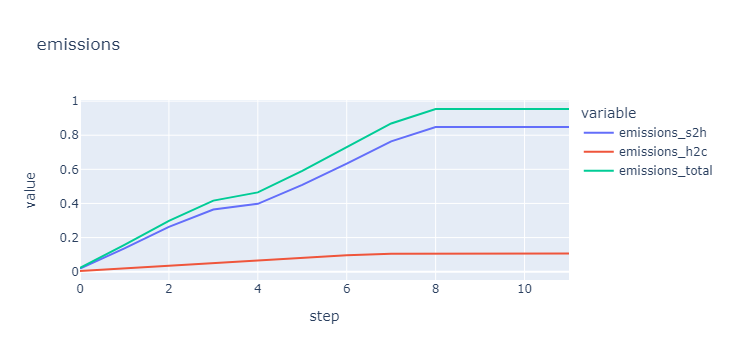

CPU times: total: 3.06 s
Wall time: 3.12 s


In [163]:
%%time
parameters_dict = {}
for name in dropdowns.keys(): 
    parameters_dict[name] = dropdowns[name].value

# create and run model 
model = Model(parameters_dict)
for i in range(12): 
    model.step()

model.visualize()

emissions (hubs to construction sites): 18 tCO2eq
emissions (suppliers to hubs): 579 tCO2eq
emissions (total): 597 tCO2eq


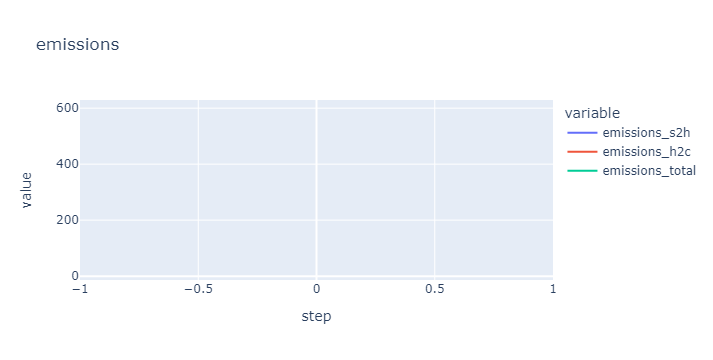

         1500714 function calls (1443858 primitive calls) in 2.214 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    0.000    0.000 2056038199.py:102(find_clients)
        2    0.000    0.000    0.000    0.000 2056038199.py:120(<listcomp>)
        2    0.000    0.000    0.000    0.000 2056038199.py:125(calc_materials_toSend)
        2    0.000    0.000    0.000    0.000 2056038199.py:135(make_materials_request)
       29    0.002    0.000    0.132    0.005 2056038199.py:18(calc_materials_required)
        2    0.000    0.000    0.000    0.000 2056038199.py:181(find_suppliers)
        4    0.000    0.000    0.000    0.000 2056038199.py:187(<listcomp>)
        2    0.000    0.000    0.000    0.000 2056038199.py:196(collect_materials_fromSupplier)
       29    0.000    0.000    0.133    0.005 2056038199.py:2(__init__)
        2    0.002    0.001    0.106    0.053 2056038199.py:214(send_materials_to

In [27]:
def test_run(): 
    parameters_dict = {}
    for name in dropdowns.keys(): 
        parameters_dict[name] = dropdowns[name].value

    # create and run model 
    model = Model(parameters_dict)
    for i in range(1): 
        model.step()

    model.visualize()
    pass

import cProfile
cProfile.run('test_run()')

In [5]:
import ipywidgets as widgets
from IPython.display import display, clear_output, IFrame
import folium

# Create an output widget to handle the display within the notebook
out = widgets.Output()

# Function to be triggered
def on_button_click(b):
    with out:
        clear_output(wait=True)  # Clear the previous output
        
        parameters_dict = {}
        for name in dropdowns.keys(): 
            parameters_dict[name] = dropdowns[name].value

        # create and run model 
        model = Model(parameters_dict)
        for i in range(10): 
            model.step()

        # visualize results 
        model.visualize()
        
        # Display the folium map using IFrame
        display(IFrame(src=model.iframe, width=700, height=400))
        
        # You can add other outputs like plotly plots or more printed text here

# Create the button
button = widgets.Button(description="Run Model")
button.on_click(on_button_click)

# Display the button and the output widget
display(button, out)


Button(description='Run Model', style=ButtonStyle())

Output()